<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-Artificial-Data" data-toc-modified-id="Generate-Artificial-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generate Artificial Data</a></span></li><li><span><a href="#Fit-the-Model!" data-toc-modified-id="Fit-the-Model!-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fit the Model!</a></span></li><li><span><a href="#Emcee-Sampler-diagnostics" data-toc-modified-id="Emcee-Sampler-diagnostics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Emcee Sampler diagnostics</a></span></li><li><span><a href="#More-diagnostics" data-toc-modified-id="More-diagnostics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>More diagnostics</a></span></li></ul></div>

In [1]:
%matplotlib inline

from gEcon.classes.model import gEconModel
from gEcon.plotting import plotting as gp
import matplotlib.pyplot as plt
import numpy as np

import arviz as az

config = {
    "figure.figsize": (14, 4),
    "figure.dpi": 144,
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

C:\Users\Jesse\Python Projects\gEcon.py\gEcon\estimation\kalman_filter.py:140: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  K = linalg.solve_triangular(F_chol, linalg.solve_triangular(F_chol, PZT.T, lower=True),


In [2]:
import statsmodels.api as sm

In [3]:
file_path = "GCN Files/RBC_complete.gcn"
model = gEconModel(file_path)

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Generate Artificial Data

Steady state found! Sum of squared residuals is 5.17689969051289e-30
Solution found, sum of squared residuals:  2.487130309183666e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


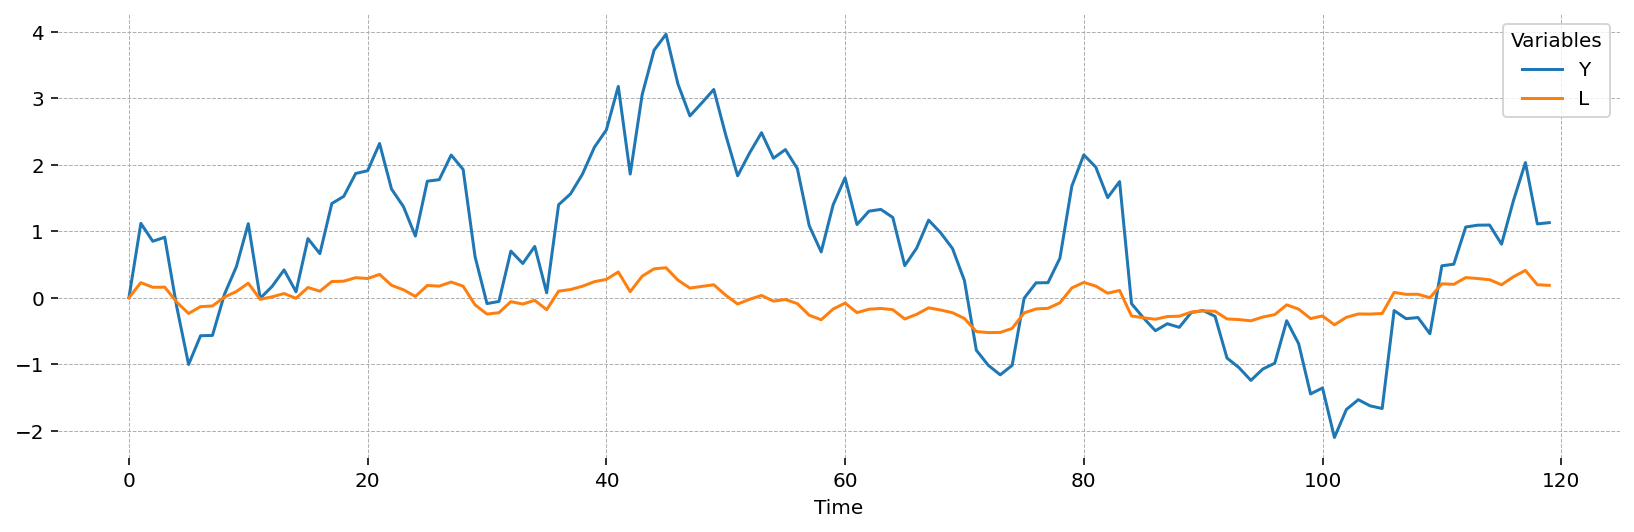

In [4]:
observed_vars = ["Y", "L"]

true_params = {
    "sigma_C": 1.35,
    "sigma_L": 2.73,
    "alpha": 0.287,
    "rho_A": 0.87,
    "rho_B": 0.52,
}
true_shocks = {"epsilon_A": 0.22}

model.free_param_dict.update(true_params)
model.steady_state()
model.solve_model()

true_params.update(true_shocks)

Sigma = np.array([[true_shocks["epsilon_A"]]])

fake_data_all = model.simulate(
    simulation_length=120, n_simulations=1, shock_cov_matrix=Sigma
).T.droplevel(1)
fake_data = fake_data_all[observed_vars].copy()

fake_data.plot();

## Fit the Model!

In [5]:
idata = model.fit(
    fake_data,
    filter_type="univariate",
    draws=10_000,
    n_walkers=36,
    return_inferencedata=True,
    burn_in=1000,
)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:12<00:00, 12.62it/s]
C:\Users\Jesse\miniconda3\envs\econ\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


## Emcee Sampler diagnostics

[Foreman-Mackey et al. (2014)](https://arxiv.org/abs/1202.3665), the authors of `emcee`, advocate two diagnostics to check that sampling has been successful: acceptance ratio and autocorrelation decay time. We can check both of these in the sampler object.

They suggest that an acceptance ratio between 0.2-0.6 is good, while autocorrelation decay should just be as low as possible. The important thing with autocorrelation is to make sure we get at least 100 independent samples. `emcee` will automatically show a warning after you call `model.fit()` if you did not get at least this many samples.

Acceptance fractions look good!

In [6]:
idata.sample_stats.acceptance_fraction

<xarray.DataArray 'acceptance_fraction' (chain: 36)>
array([0.4884, 0.4921, 0.4998, 0.4883, 0.4955, 0.4858, 0.4876, 0.4921,
       0.4948, 0.495 , 0.4901, 0.498 , 0.4972, 0.4954, 0.494 , 0.4969,
       0.4972, 0.4977, 0.4882, 0.4904, 0.4953, 0.4965, 0.4929, 0.4977,
       0.4953, 0.502 , 0.4952, 0.4957, 0.4913, 0.5069, 0.4991, 0.4955,
       0.49  , 0.4974, 0.496 , 0.4869])
Coordinates:
  * chain    (chain) int32 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35

We can see the sampler struggled with the standard error on `epsilon_B`, the household preference shock. 

In [7]:
idata.sample_stats.autocorrelation_time

<xarray.DataArray 'autocorrelation_time' (parameters: 5)>
array([24.06681195, 23.4198493 , 29.45044097, 24.30699449, 29.08817132])
Coordinates:
  * parameters  (parameters) <U9 'sigma_C' 'sigma_L' 'alpha' 'rho_A' 'epsilon_A'

## More diagnostics

In addition to the Emcee diagnostics, we can run additional checks using the `Arviz` package. First we will convert the sampler to an arviz `idata` object, giving names to the variables.

The r-hat is a common measure of chain mixing. If all the chains from our sampler converge to the same distribution, the r-hat statistic is 1.0. The higher it is, the worse the chains "mix", suggesting that the sampler failed to converge on a single distribution. We don't want to see anything above 1.05. Here our chains look OK.

In [8]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_C,1.242,0.087,1.074,1.404,0.001,0.001,13269.0,25302.0,1.0
sigma_L,1.251,0.086,1.090,1.415,0.001,0.001,13460.0,24832.0,1.0
alpha,0.216,0.116,0.021,0.427,0.001,0.001,10882.0,20181.0,1.0
rho_A,0.928,0.027,0.876,0.978,0.000,0.000,12898.0,22081.0,1.0
epsilon_A,0.198,0.029,0.147,0.254,0.000,0.000,11723.0,14646.0,1.0


The best check is always visual. We can see that things mostly converged, but there is a lot of noise in the chains. The bad chains in Epsilon B are visible, as are some chains for alpha and rho_A that got stuck.

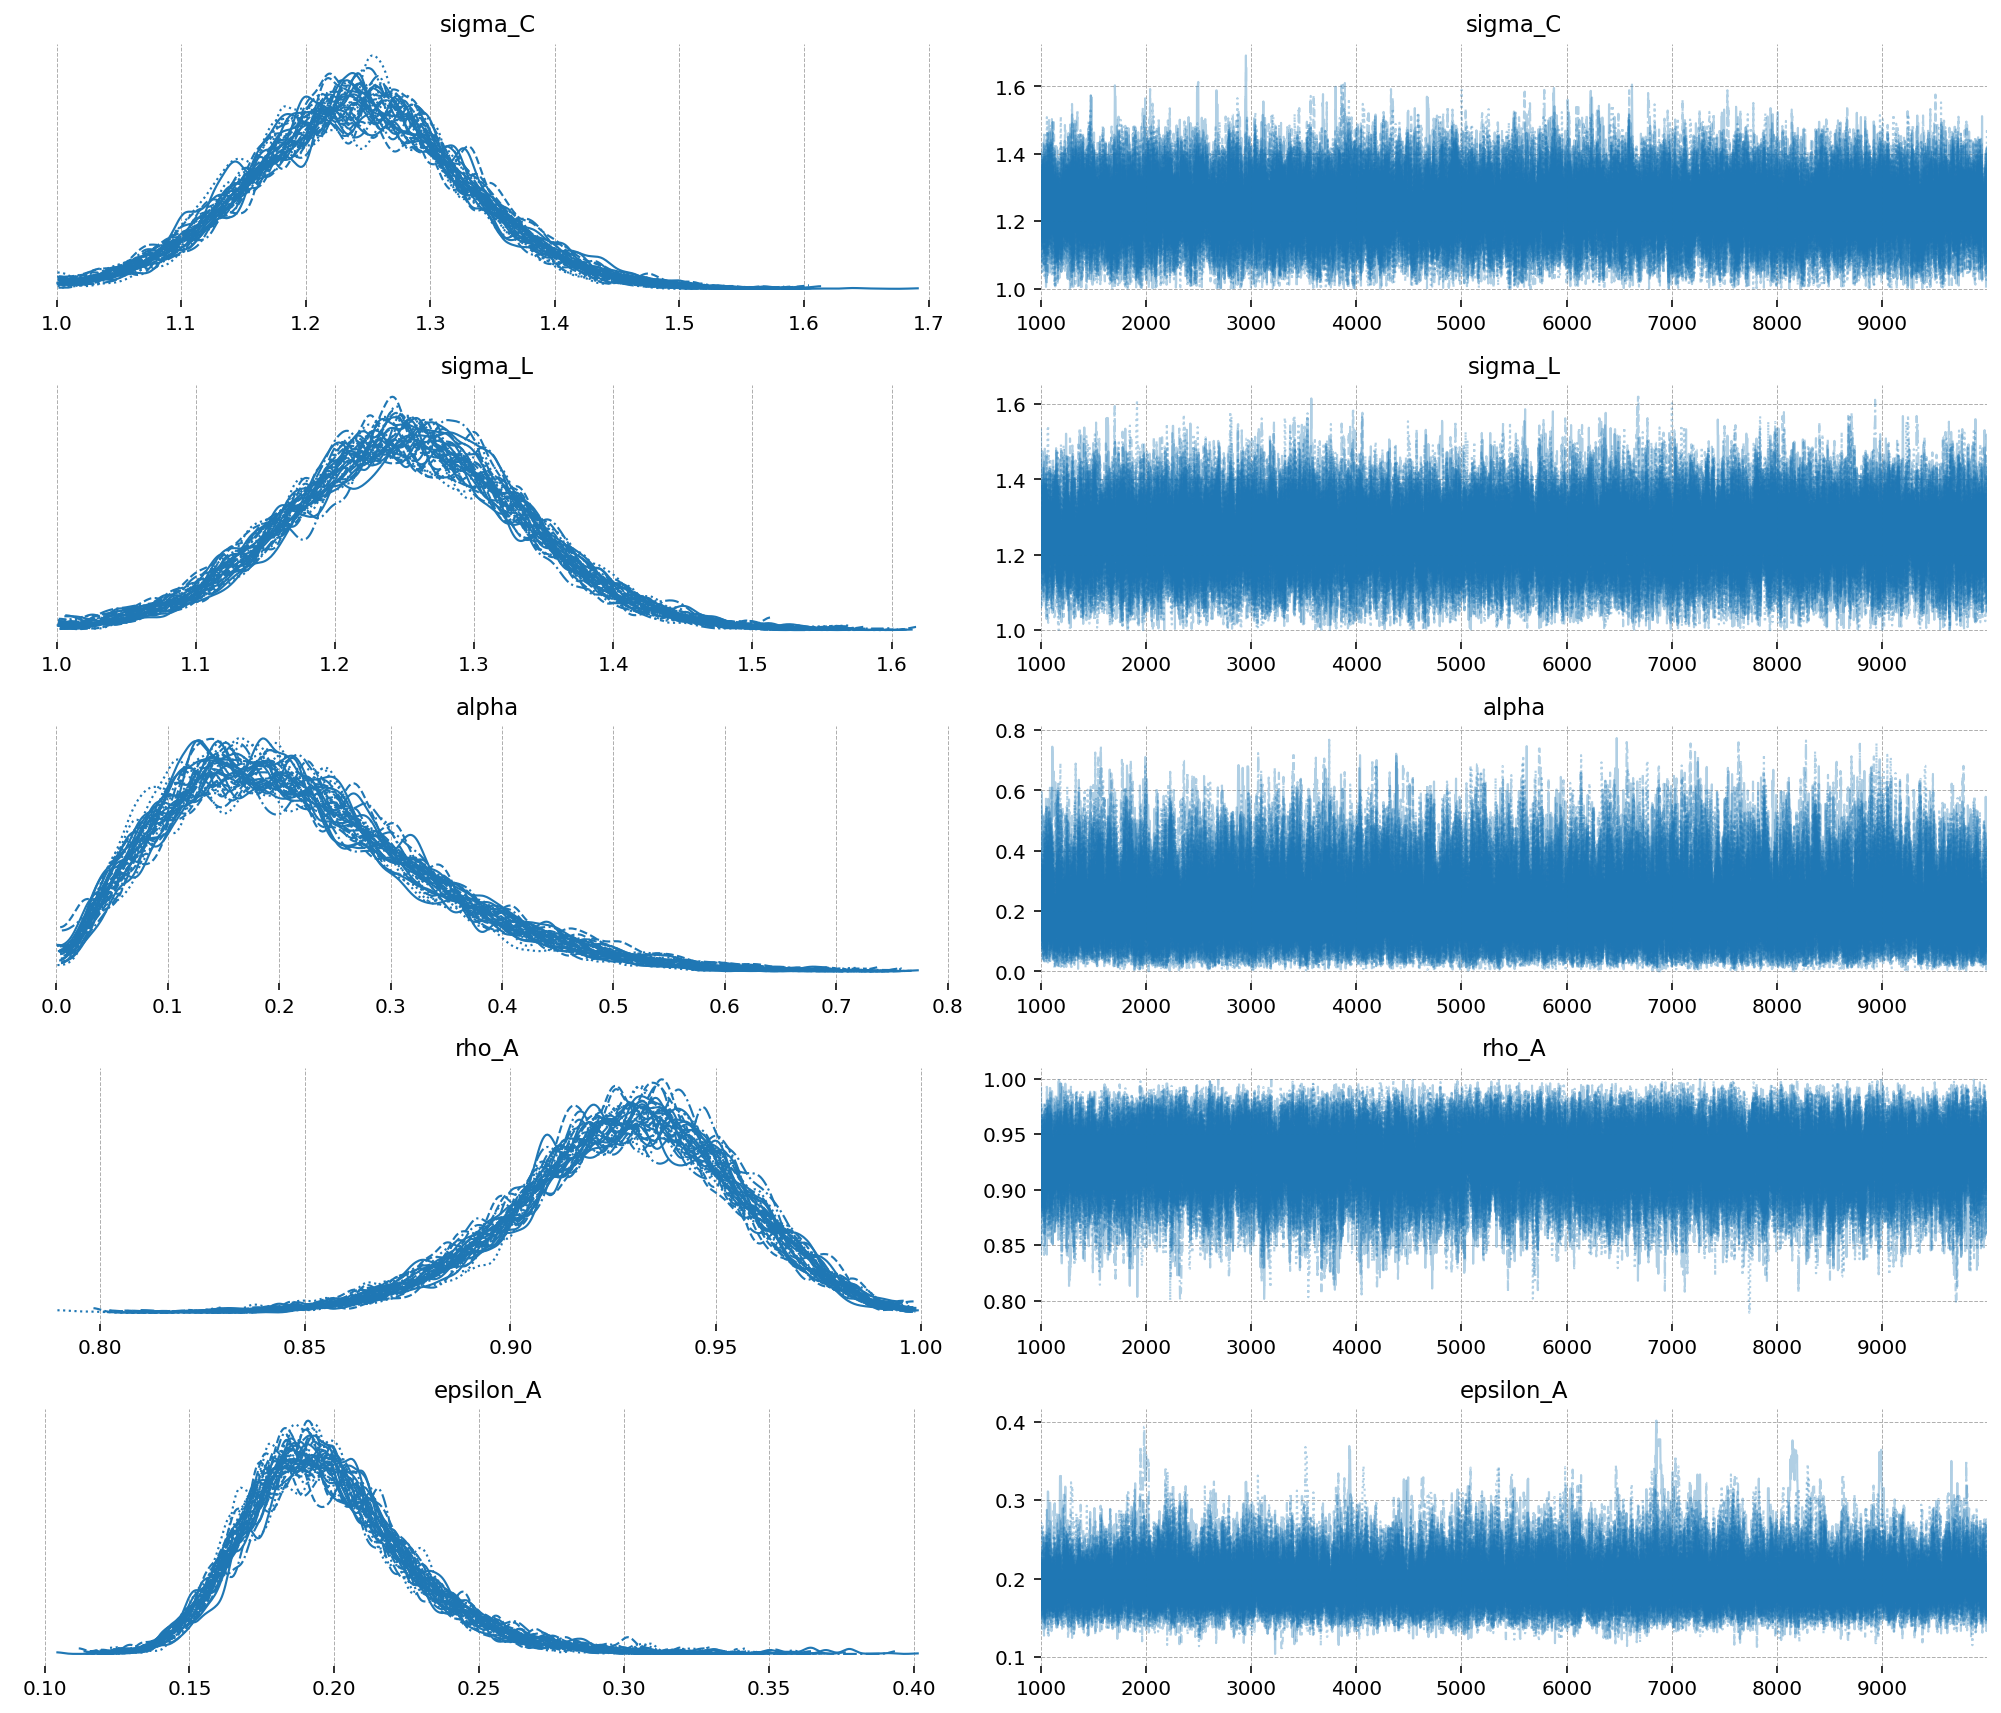

In [10]:
fig, ax = plt.subplots(5, 2, figsize=(14, 12), dpi=144)
az.plot_trace(idata.sel(draw=slice(1000, None)), axes=ax)
fig.tight_layout()
plt.show()

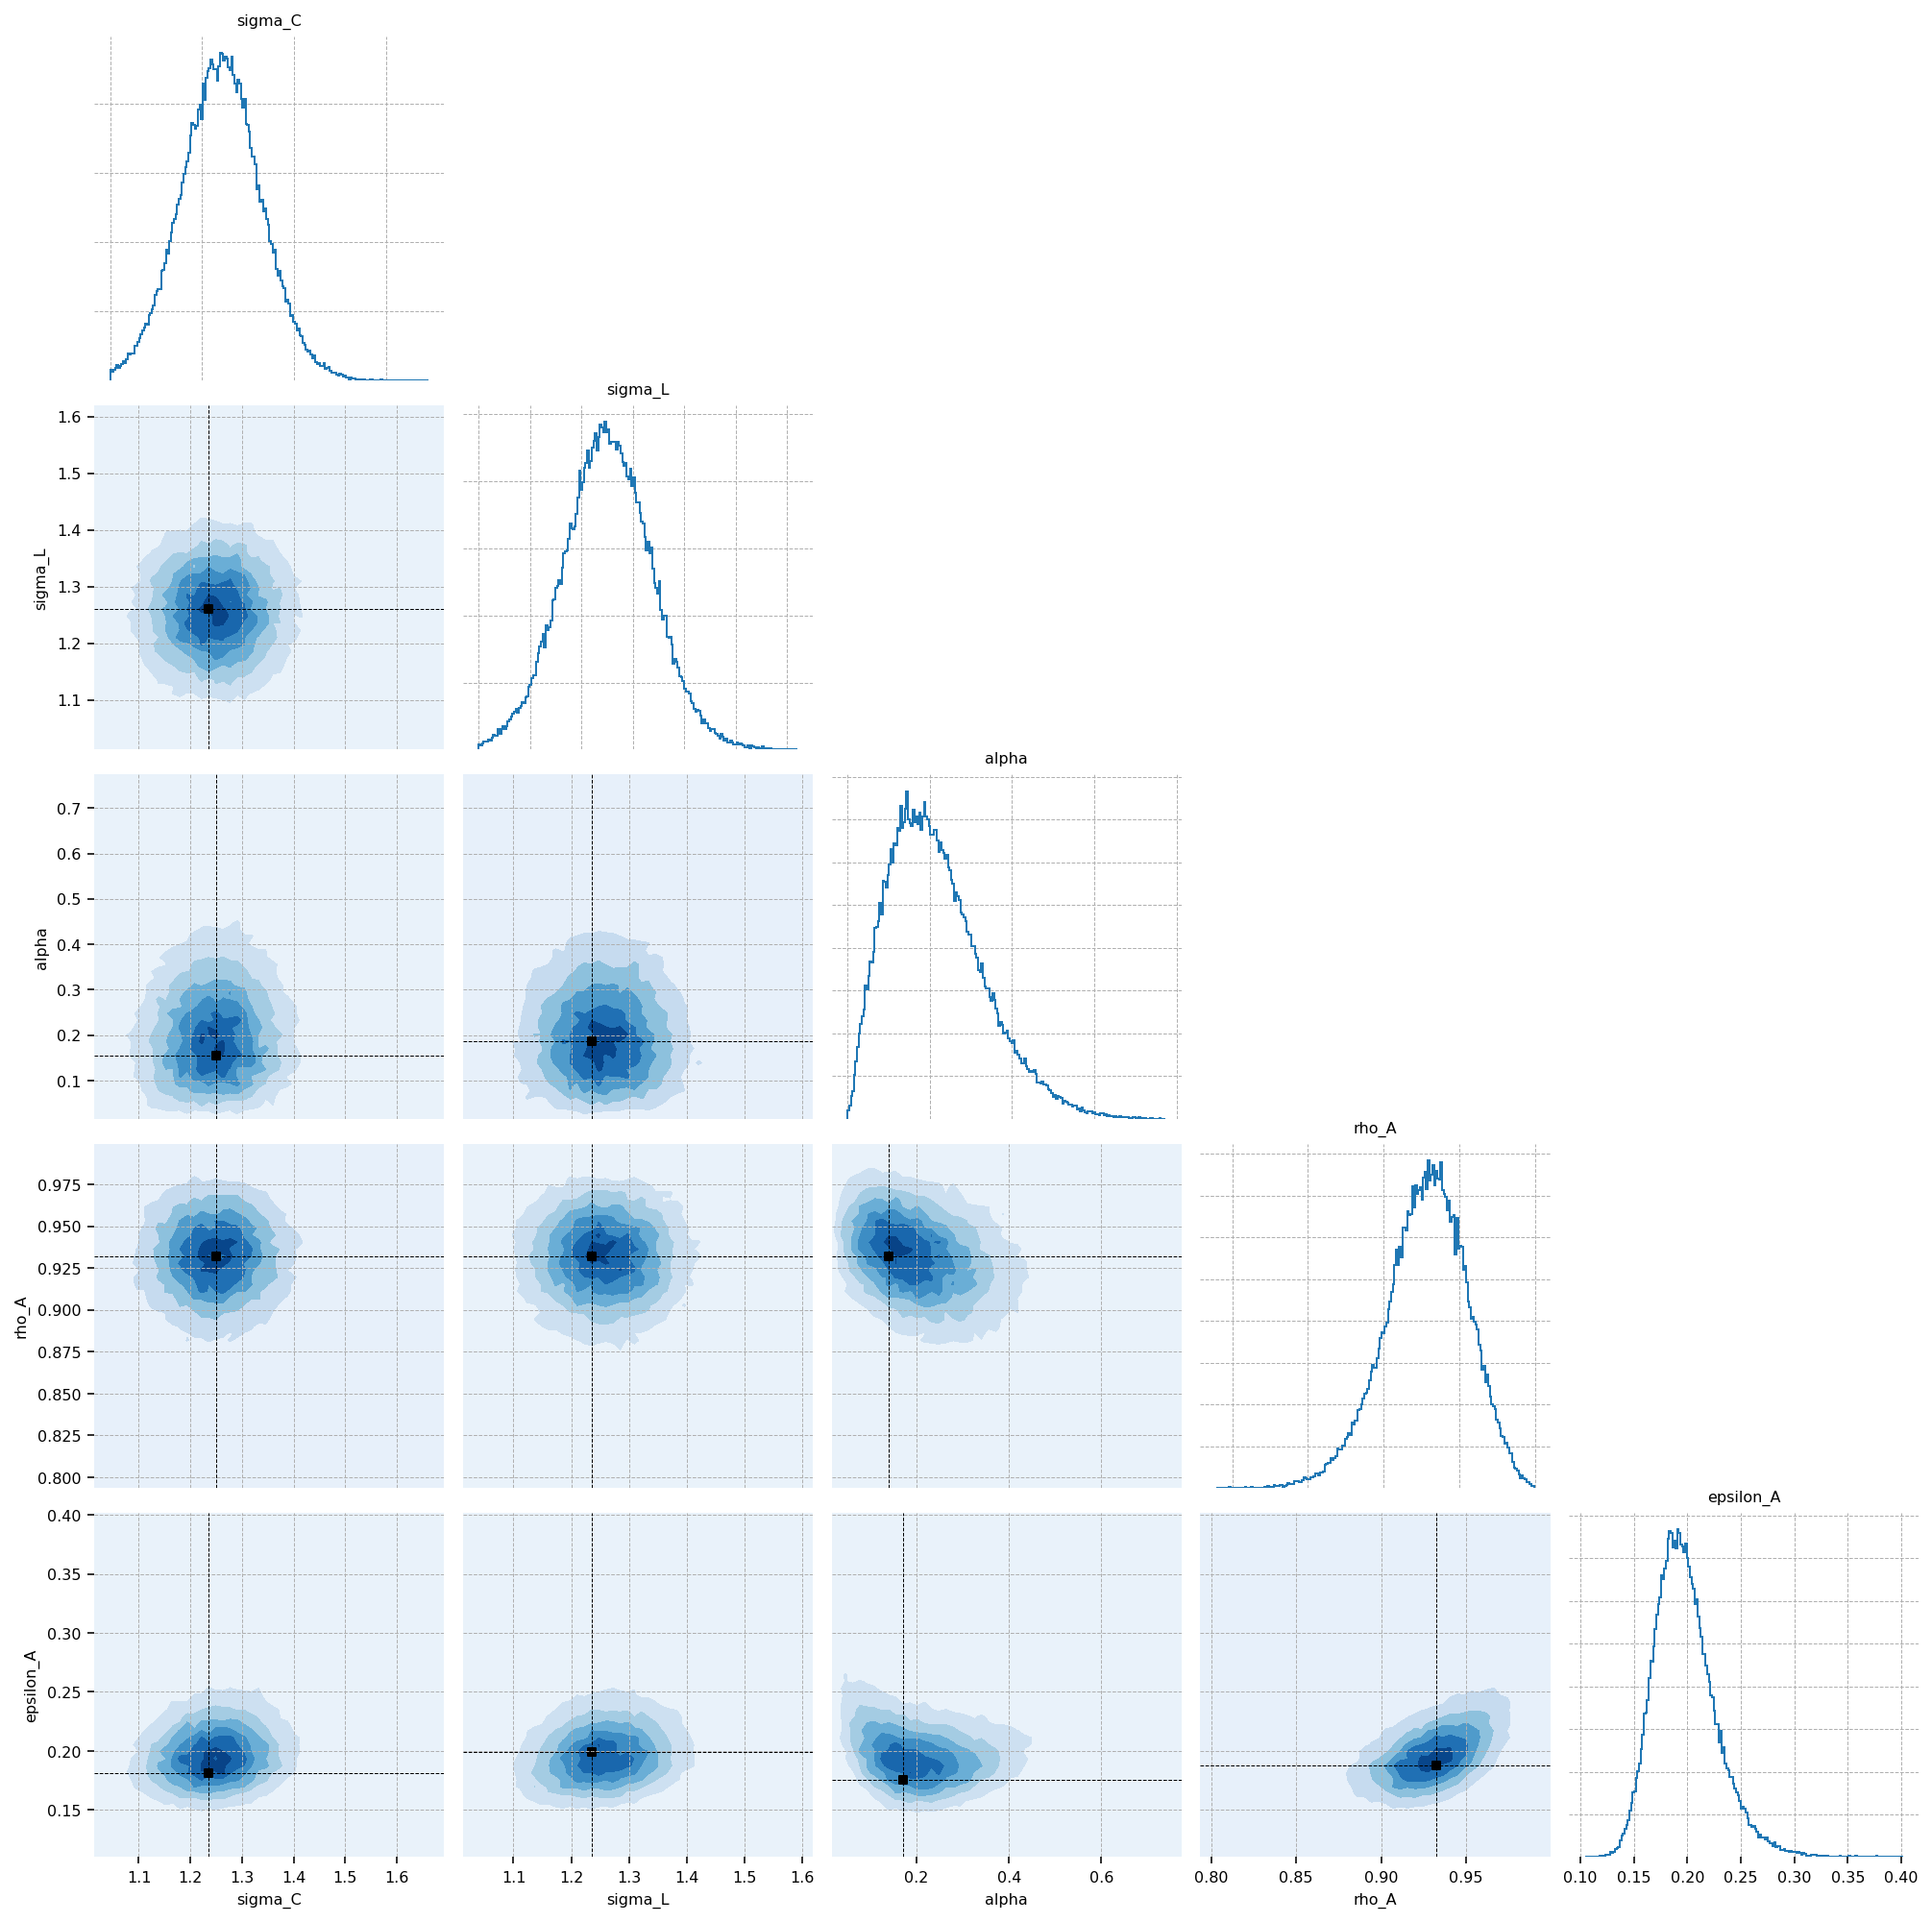

In [11]:
gp.plot_corner(idata.sel(draw=slice(1000, None)))

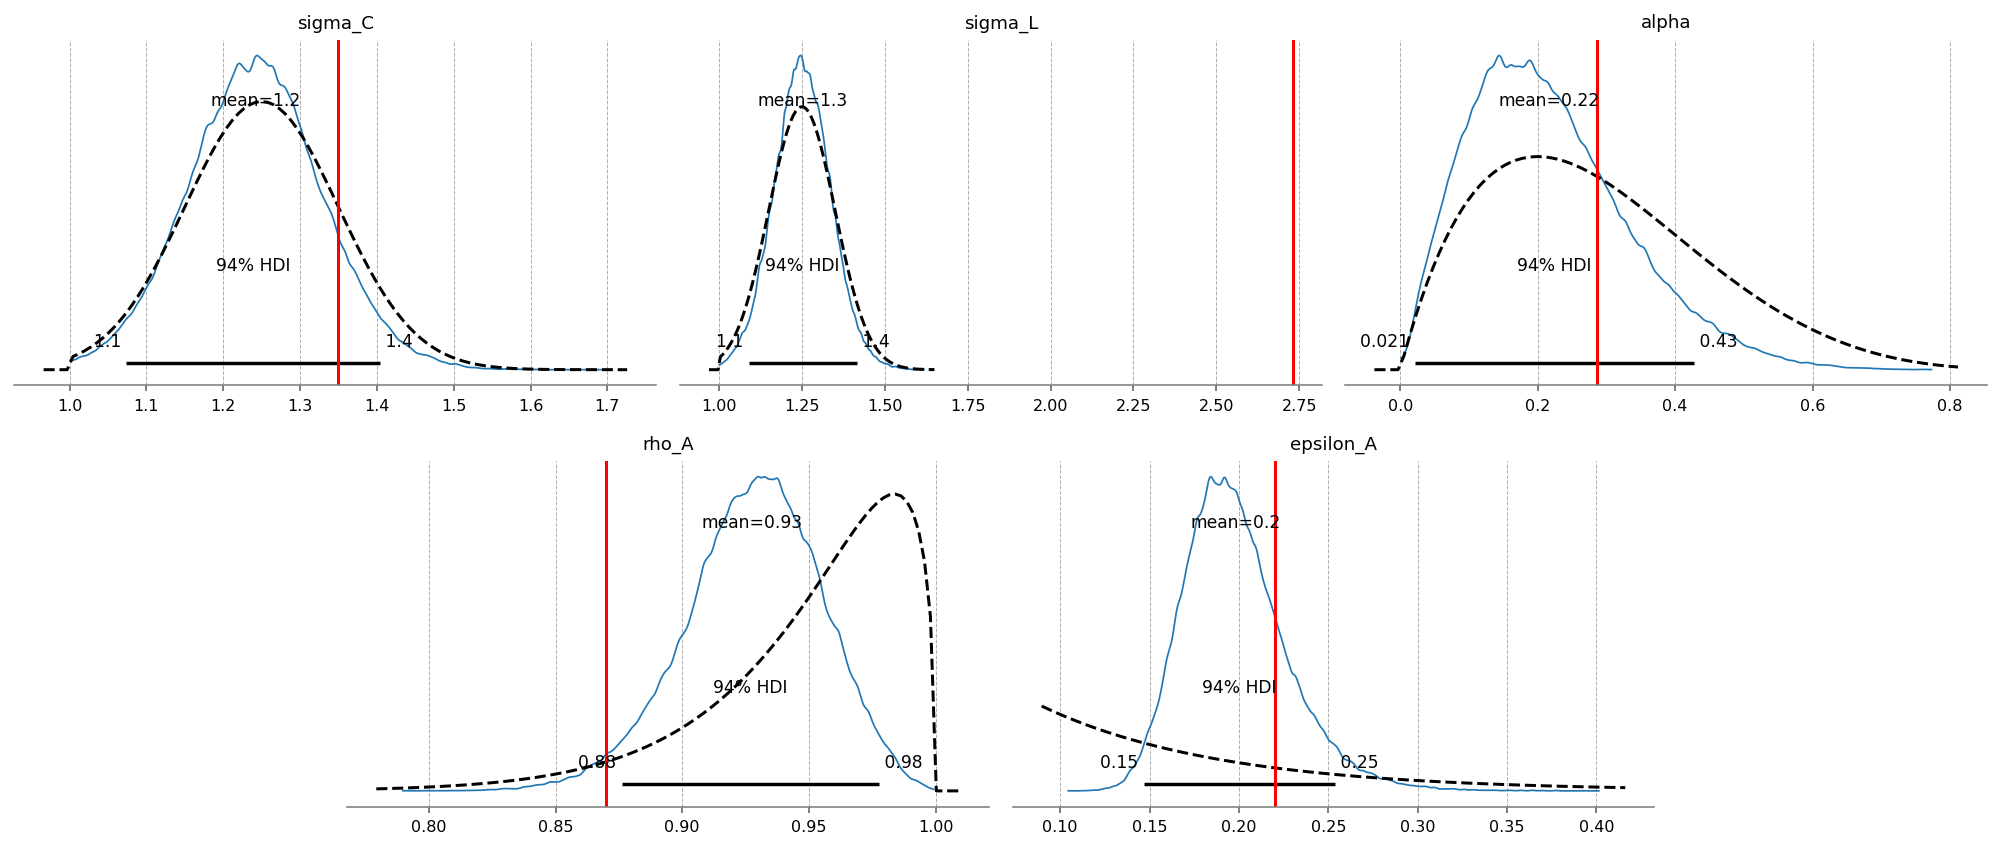

In [13]:
from gEcon.estimation.estimation_utilities import extract_prior_dict

prior_dict = extract_prior_dict(model)
true_params.update(true_shocks)

fig = plt.figure(figsize=(14, 6))
gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=5)

for loc in plot_locs:
    axis = fig.add_subplot(gs[loc])

axes = az.plot_posterior(idata, figsize=(14, 6), textsize=8, ax=fig.axes)
for i, axis in enumerate(axes):
    xlim = axis.get_xlim()
    x_grid = np.linspace(*xlim, 100)
    param = axis.get_title()
    axis.plot(x_grid, prior_dict[param].pdf(x_grid), c="k", ls="--")
    axis.axvline(true_params[param], c="r")
fig.tight_layout()